In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Preprocess of the PAMAP2 DataSet

In [2]:
#Creates overlapping windows from the input data.
def create_windows(data, window_size, step_size):
    windows = []
    for i in range(0, data.shape[0] - window_size + 1, step_size):
        windows.append(data[i:i + window_size])
    return np.array(windows)

In [3]:
# Downsample IMU data to 30Hz (from 100Hz)
def downsample_imus(df, target_freq=30, original_freq=100):
    ratio = int(original_freq / target_freq)
    # Downsample all columns except heart rate
    imu_cols = [col for col in df.columns if col not in ['heartrate', 'timestamp', 'activityID', 'subject_id']]
    df_imus = df[imu_cols].iloc[::ratio].reset_index(drop=True)
    # For heart rate, interpolate to match new length
    hr = df['heartrate'].interpolate().values
    hr_down = np.interp(
        np.linspace(0, len(hr)-1, num=len(df_imus)),
        np.arange(len(hr)),
        hr
    )
    # Rebuild DataFrame
    df_down = pd.DataFrame(df_imus)
    df_down['heartrate'] = hr_down
    # Add back activityID, timestamp, subject_id (downsampled to match IMU)
    for col in ['activityID', 'timestamp', 'subject_id']:
        if col in df.columns:
            vals = df[col].values
            vals_down = np.interp(
                np.linspace(0, len(vals)-1, num=len(df_imus)),
                np.arange(len(vals)),
                vals
            )
            # For activityID and subject_id, round to nearest int
            if col in ['activityID', 'subject_id']:
                vals_down = np.round(vals_down).astype(int)
            df_down[col] = vals_down
    # Reorder columns
    cols = ['timestamp', 'activityID', 'heartrate'] + [c for c in df_down.columns if c not in ['timestamp', 'activityID', 'heartrate']]
    return df_down[cols]

In [4]:
def split_by_class_time(X, y, train_size=0.6, val_size=0.2, test_size=0.2):
    X_train, X_val, X_test = [], [], []
    y_train, y_val, y_test = [], [], []
    classes = np.unique(y)
    for c in classes:
        idx = np.where(y == c)[0]
        n = len(idx)
        n_train = int(n * train_size)
        n_val = int(n * val_size)
        X_c, y_c = X[idx], y[idx]
        X_train.append(X_c[:n_train])
        y_train.append(y_c[:n_train])
        X_val.append(X_c[n_train:n_train + n_val])
        y_val.append(y_c[n_train:n_train + n_val])
        X_test.append(X_c[n_train + n_val:])
        y_test.append(y_c[n_train + n_val:])
    return (np.concatenate(X_train), np.concatenate(y_train),
            np.concatenate(X_val), np.concatenate(y_val),
            np.concatenate(X_test), np.concatenate(y_test))

In [5]:
list_of_files = ['./ProtocolData/subject101.dat',
                './ProtocolData/subject102.dat',
                './ProtocolData/subject103.dat',
                './ProtocolData/subject104.dat',
                './ProtocolData/subject105.dat',
                './ProtocolData/subject106.dat',
                './ProtocolData/subject107.dat',
                './ProtocolData/subject108.dat',
                './ProtocolData/subject109.dat']

In [6]:
colNames = ["timestamp", "activityID", "heartrate"]

IMUhand = ['handTemperature',
            'handAcc16_1', 'handAcc16_2', 'handAcc16_3',
            'handAcc6_1', 'handAcc6_2', 'handAcc6_3',
            'handGyro1', 'handGyro2', 'handGyro3',
            'handMagne1', 'handMagne2', 'handMagne3',
            'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4']

IMUchest = ['chestTemperature',
            'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3',
            'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3',
            'chestGyro1', 'chestGyro2', 'chestGyro3',
            'chestMagne1', 'chestMagne2', 'chestMagne3',
            'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4']

IMUankle = ['ankleTemperature',
            'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3',
            'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3',
            'ankleGyro1', 'ankleGyro2', 'ankleGyro3',
            'ankleMagne1', 'ankleMagne2', 'ankleMagne3',
            'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4']

columns = colNames + IMUhand + IMUchest + IMUankle

In [7]:
dataCollection = pd.DataFrame()

for file in list_of_files:
    procData = pd.read_table(file, header=None, sep='\s+')
    procData.columns = columns
    procData['subject_id'] = int(file[-5])
    dataCollection = pd.concat([dataCollection, procData], ignore_index=True)

dataCollection.reset_index(drop=True, inplace=True)

In [8]:
def dataCleaning(dataCollection):
    cols_to_drop = [
        'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4',
        'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4',
        'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4'
    ]



    cols_to_drop = [col for col in cols_to_drop if col in dataCollection.columns]
    dataCollection = dataCollection.drop(cols_to_drop, axis=1, errors='ignore')
    dataCollection = dataCollection.drop(dataCollection[dataCollection.activityID == 0].index)
    dataCollection = dataCollection.apply(pd.to_numeric, errors='coerce')
    dataCollection = dataCollection.interpolate()


    # Keep only the desired activity IDs
    valid_activity_ids = [1, 2, 3, 4, 5, 6, 7, 12, 13, 16, 17, 24]
    dataCollection = dataCollection[dataCollection['activityID'].isin(valid_activity_ids)]

    # Remap activity IDs to make it go from 0 to 11
    activity_id_mapping = {
        1:0,
        2:1,
        3:2,
        4:3,
        5:4,
        6:5,
        7:6,
        12: 7,
        13: 8,
        16: 9,
        17: 10,
        24: 11
    }
    dataCollection['activityID'] = dataCollection['activityID'].replace(activity_id_mapping).astype(int)

    return dataCollection

In [9]:
dataCol = dataCleaning(dataCollection)

dataCol.reset_index(drop=True, inplace=True)

dataCol = downsample_imus(dataCol, target_freq=30, original_freq=100)

for i in range(0,4):
    dataCol.loc[i,"heartrate"]=100

X = dataCol.drop(['activityID', "timestamp", "subject_id"], axis=1)
y = dataCol['activityID']

In [10]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
# Apply time windowing
window_size = 128
step_size = 64
X_windowed = create_windows(X_scaled, window_size, step_size)

In [12]:
# Get corresponding labels for each window
y_windowed = []
for i in range(0, X_scaled.shape[0] - window_size + 1, step_size):
    window_labels = y[i:i + window_size]
    y_windowed.append(int(pd.Series(window_labels).mode()[0]))
y_windowed = np.array(y_windowed)

In [13]:
def balance_windows(X_windowed, y_windowed, min_count=100):
    # For each class, duplicate windows until min_count
    X_balanced, y_balanced = [], []
    classes, counts = np.unique(y_windowed, return_counts=True)
    for c, count in zip(classes, counts):
        idx = np.where(y_windowed == c)[0]
        X_c, y_c = X_windowed[idx], y_windowed[idx]
        n_repeat = int(np.ceil(min_count / count))
        X_balanced.append(np.tile(X_c, (n_repeat, 1, 1))[:min_count])
        y_balanced.append(np.tile(y_c, n_repeat)[:min_count])
    X_balanced = np.concatenate(X_balanced)
    y_balanced = np.concatenate(y_balanced)
    return X_balanced, y_balanced

In [14]:
X_bal, y_bal = balance_windows(X_windowed, y_windowed, min_count=1000)

In [15]:
train_X, train_y, val_X, val_y, test_X, test_y = split_by_class_time(
    X_bal, y_bal, train_size=0.70, val_size=0.15, test_size=0.15
)

In [16]:
print("train x shape:",train_X.shape)
print("train y shape:",train_y.shape)
print("test x shape:",test_X.shape)
print("test y shape:",test_y.shape)
print("validation x shape:",val_X.shape)
print("validation y shape:",val_y.shape)

train x shape: (8400, 128, 40)
train y shape: (8400,)
test x shape: (1800, 128, 40)
test y shape: (1800,)
validation x shape: (1800, 128, 40)
validation y shape: (1800,)


In [17]:
# Save the data as numpy arrays with the specified variable names
np.save('train_X.npy', train_X)
np.save('train_y.npy', train_y)
np.save('val_X.npy', val_X)
np.save('val_Y.npy', val_y)
np.save('test_X.npy', test_X)
np.save('test_Y.npy', test_y)

print("Data successfully saved as NumPy arrays: train_X.npy, train_y.npy, test_X.npy, test_Y.npy, val_X.npy, val_Y.npy")

Data successfully saved as NumPy arrays: train_X.npy, train_y.npy, test_X.npy, test_Y.npy, val_X.npy, val_Y.npy


# CNN

In [18]:
import torch
import math
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.nn import init
from sklearn.metrics import recall_score, f1_score, accuracy_score
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
import os
import gc


In [19]:
# Enable PyTorch memory optimization features
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True,max_split_size_mb:128'

gc.collect()  # Force garbage collection before starting

20

In [20]:
torch.cuda.set_device(0)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
n_gpu = torch.cuda.device_count()
print(n_gpu)
path = os.path.dirname(os.path.abspath("__file__"))
print(path)

1
C:\Users\cloth\Desktop\research-project\PAMAP2


In [21]:
pathlist = ['./train_X.npy',
            './train_y.npy',
            './val_X.npy',
            './val_y.npy',
            './test_X.npy',
            './test_Y.npy']


In [22]:
def similarity_matrix(x, chunk_size=32):
    ''' Calculate adjusted cosine similarity matrix of size x.size(0) x x.size(0) with memory optimization. '''
    # Free memory before computation
    torch.cuda.empty_cache()

    # Process input tensor based on dimensions
    if x.dim() == 4:
        if x.size(1) > 3 and x.size(2) > 1:
            z = x.view(x.size(0), x.size(1), -1)
            x = z.std(dim=2)
        else:
            x = x.view(x.size(0), -1)

    # Center the data
    xc = x - x.mean(dim=1).unsqueeze(1)

    # Normalize
    xn = xc / (1e-8 + torch.sqrt(torch.sum(xc ** 2, dim=1))).unsqueeze(1)

    # Use chunking for large matrices to reduce memory usage
    batch_size = xn.size(0)

    # If batch is small enough, compute directly
    if batch_size <= chunk_size:
        R = xn.matmul(xn.transpose(1, 0)).clamp(-1, 1)
        return R

    # For larger batches, compute similarity matrix in chunks
    R = torch.zeros(batch_size, batch_size, device=xn.device)

    for i in range(0, batch_size, chunk_size):
        end_i = min(i + chunk_size, batch_size)
        chunk_i = xn[i:end_i]

        for j in range(0, batch_size, chunk_size):
            end_j = min(j + chunk_size, batch_size)
            chunk_j = xn[j:end_j]

            # Compute similarity for this chunk
            R[i:end_i, j:end_j] = chunk_i.matmul(chunk_j.transpose(1, 0)).clamp(-1, 1)

            # Free memory after each chunk computation
            torch.cuda.empty_cache()

    return R


In [23]:
def data_flat(data_y):
    # Check if data_y is 1D or multi-dimensional
    if data_y.ndim == 1:
        # If 1D, return as is
        return data_y
    else:
        # If multi-dimensional, use argmax along axis 1
        return np.argmax(data_y, axis=1)

In [24]:
def load_data(train_x_path, train_y_path, batchsize):
    # Clear GPU memory before loading data
    torch.cuda.empty_cache()

    # Load the data using memory mapping to avoid loading entire array into memory
    train_x_mmap = np.load(train_x_path, mmap_mode='r')
    train_y_mmap = np.load(train_y_path, mmap_mode='r')

    # Get original data size
    original_size = train_x_mmap.shape[0]

    # Use only 1/2 of the data to reduce memory usage
    subset_size = original_size

    # Get data dimensions
    if len(train_x_mmap.shape) == 3:
        channels = 1
        height = train_x_mmap.shape[1]
        width = train_x_mmap.shape[2]
    else:
        channels = train_x_mmap.shape[1]
        height = train_x_mmap.shape[2]
        width = train_x_mmap.shape[3]

    # Display the size of the data
    print('Original data size:', original_size)
    print('Using all of data:', subset_size)
    print('Data shape after reduction:', (subset_size, channels, height, width))

    # Create a custom dataset that loads data in chunks
    class MemoryEfficientDataset(Data.Dataset):
        def __init__(self, x_mmap, y_mmap, subset_size):
            self.x_mmap = x_mmap
            self.y_mmap = y_mmap
            self.subset_size = min(subset_size, x_mmap.shape[0])

            # Calculate class distribution
            if y_mmap.ndim == 1:
                # Sample a small portion to get class distribution
                sample_size = min(1000, self.subset_size)
                sample_indices = np.random.choice(self.subset_size, sample_size, replace=False)
                sample_y = np.array(y_mmap[sample_indices])
                unique_classes, counts = np.unique(sample_y, return_counts=True)
            else:
                sample_size = min(1000, self.subset_size)
                sample_indices = np.random.choice(self.subset_size, sample_size, replace=False)
                sample_y = np.array(y_mmap[sample_indices])
                unique_classes, counts = np.unique(np.argmax(sample_y, axis=1), return_counts=True)

            print('\nDistribution of activities in training data (sampled):')
            for cls, count in zip(unique_classes, counts):
                print(f'Activity {cls}: {count} samples ({count/sample_size*100:.2f}%)')

        def __len__(self):
            return self.subset_size

        def __getitem__(self, idx):
            # Load single sample on demand
            if idx < self.subset_size:
                # Convert to float32 to reduce memory usage
                x = np.array(self.x_mmap[idx], dtype=np.float32)
                y = np.array(self.y_mmap[idx])

                # Reshape if needed
                if len(x.shape) == 2:
                    x = x.reshape(1, x.shape[0], x.shape[1])

                # Convert to torch tensors
                x_tensor = torch.from_numpy(x).float()
                y_tensor = torch.from_numpy(y)

                return x_tensor, y_tensor
            else:
                raise IndexError("Index out of bounds")

    # Create dataset and dataloader
    dataset = MemoryEfficientDataset(train_x_mmap, train_y_mmap, subset_size)

    # Use a DataLoader with pin_memory for faster GPU transfer
    loader = Data.DataLoader(
        dataset=dataset,
        batch_size=batchsize,
        shuffle=False,
        num_workers=0,
        pin_memory=True,  # This speeds up the host to GPU transfer
    )

    # Print shape information
    print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n',
          f'Batches: {len(loader)}, Batch size: {batchsize}, Total samples: {len(dataset)}',
          '\n^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')

    return loader

In [25]:
def quzheng_x(height, kernel_size, padding, stride, numlayer):
    list = []
    for i in range(1, numlayer + 1):
        feature = int((height - kernel_size + 2 * padding) / stride) + 1
        height = feature
        list.append(feature)
    return list

In [26]:
def quzheng_s(height, kernel_size, padding, stride, numlayer):
    list = []
    for i in range(1, numlayer + 1):
        torch.cuda.empty_cache()
        feature = math.ceil((height - kernel_size + 2 * padding) / stride) + 1
        height = feature
        list.append(feature)
        torch.cuda.empty_cache()
    return list

In [27]:
class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
        print('this is loss function!')

    def forward(self, output, label):
        loss_func = F.cross_entropy(output, label)
        return loss_func

In [28]:
class conv_loss_block(nn.Module):
    def __init__(self, channel_in, channel_out, height_width, kernel, stride, bias,numlayer):
        super(conv_loss_block, self).__init__()
        self.channel_in = channel_in
        self.channel_out = channel_out
        self.height_width = height_width
        self.num_class = 12
        self.bias = bias
        self.dropout_p = 0.3 #avant à 5
        self.batchnorm = True
        self.decode_ys=[]
        self.bns_decode_ys = []

        decode_t_list = [204672, 116736, 42624]
        # print(int(channel_out*height_width*0.5),'self.biasself.biasself.biasself.biasself.bias')
        print(channel_in, channel_out, height_width, kernel, stride, bias,'channel_in, channel_out, height_width, kernel, stride, bias')

        self.relu=nn.ReLU(inplace=True)
        self.encoder = nn.Sequential(
            nn.Conv2d(channel_in, channel_out, (6,2), stride=stride, padding=0, bias=self.bias),
            nn.BatchNorm2d(channel_out),
            nn.LeakyReLU(inplace=True),

        )


        for i in range(3):
            decode_y = nn.Linear(decode_t_list[i], 12)
            setattr(self, 'decode_y%i' % i, decode_y)
            self._set_init(decode_y)
            self.decode_ys.append(decode_y)



        self.conv_loss = nn.Sequential(
            nn.Conv2d(channel_out, channel_out, kernel_size=(2,1), stride=(2,1), padding=(1,0), bias=False),
            # nn.BatchNorm2d(channel_out,momentum=0.5)
                                       )


        if self.batchnorm:
            self.bn = torch.nn.BatchNorm2d(channel_out, momentum=0.5)
            nn.init.constant_(self.bn.weight, 1)
            nn.init.constant_(self.bn.bias, 0)

        self.nonlin = nn.ReLU(inplace=True)
        self.dropout = torch.nn.Dropout(p=self.dropout_p, inplace=False)
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)



        self.clear_stats()
    def _set_init(self, layer):
        init.normal_(layer.weight, mean=0., std=.1)
        init.constant_(layer.bias, 0.2)

    def clear_stats(self):
        self.loss_sim = 0.0
        self.loss_pred = 0.0
        self.correct = 0
        self.examples = 0

    def print_stats(self):
        stats = '{}, loss_sim={:.4f}, loss_pred={:.4f}, error={:.3f}%, num_examples={}\n'.format(
            self.encoder,
            self.loss_sim / self.examples,
            self.loss_pred / self.examples,
            100.0 * float(self.examples - self.correct) / self.examples,
            self.examples)
        return stats

    def set_learning_rate(self, lr):
        self.lr = lr
        # print('lr:', self.optimizer.param_groups[0]['lr'])
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.lr

    def optim_zero_grad(self):
        self.optimizer.zero_grad()

    def optim_step(self):
        self.optimizer.step()

    def forward(self, x, y, y_onehot, loop, is_training):
        # Free memory before computation
        torch.cuda.empty_cache()

        # Encode input
        h = self.encoder(x)

        h_return = h
        h_return = self.dropout(h_return)

        # Apply convolution for loss calculation
        h_loss = self.conv_loss(h)

        # Calculate similarity matrices with memory-efficient implementation
        # Use smaller chunk size for validation to reduce memory usage
        chunk_size = 16 if not is_training else 32

        # Calculate similarity matrix for h_loss
        Rh = similarity_matrix(h_loss, chunk_size=chunk_size)

        # Calculate loss components
        h_pool = h_return

        # Flatten and pass through decoder
        h_pool_flat = h_pool.view(h_pool.size(0), -1)
        y_hat_local = self.decode_ys[loop](h_pool_flat)

        # Calculate prediction loss
        loss_pred = (1 - 0.99) * F.cross_entropy(y_hat_local, y.detach().long())

        # Calculate similarity loss
        if is_training:
            # During training, use full similarity calculation
            Ry = similarity_matrix(y_onehot, chunk_size=chunk_size).detach()
            loss_sim = 0.99 * F.mse_loss(Rh, Ry)

            # Calculate unsupervised loss only during training
            Rx = similarity_matrix(x, chunk_size=chunk_size).detach()
            loss_unsup = F.mse_loss(Rh, Rx)
        else:
            # During validation, use a simplified approach to save memory
            with torch.amp.autocast('cuda'):
                Ry = similarity_matrix(y_onehot, chunk_size=chunk_size).detach()
                loss_sim = 0.99 * F.mse_loss(Rh, Ry)
                loss_unsup = 0.0  # Skip unsupervised loss during validation

        # Combine losses
        loss_sup = loss_pred + loss_sim
        loss = loss_sup * 1 + loss_unsup * 0

        # Backpropagation (only during training)
        if is_training:
            loss.backward(retain_graph=False)
            self.optimizer.step()
            self.optimizer.zero_grad()
            h_return.detach_()

        # Free memory
        torch.cuda.empty_cache()

        # Return loss as scalar
        loss_value = loss.item()

        return h_return, loss_value

In [29]:
class convnet(nn.Module):
    def __init__(self, input_ch, output_ch, height, num_layers, num_hiden, num_classes,lr):
        super(convnet, self).__init__()
        self.num_hidden = num_hiden
        self.num_layers = num_layers
        self.height = height
        self.input_ch = input_ch
        self.output_ch = output_ch
        reduce_factor = 1
        self.bn=[]


        self.layers = nn.ModuleList(
            [conv_loss_block(self.input_ch, self.output_ch, self.height, kernel=(6,2), stride=(3,1), bias=False,numlayer=num_layers)])
        self.layers.extend(
            [conv_loss_block(self.output_ch, 256, self.height, kernel=(6,2), stride=(3,1), bias=False,numlayer=num_layers),
             conv_loss_block(256, 384, self.height, kernel=(6,2), stride=(3,1), bias=False,numlayer=num_layers)
             ])

        self.layer_out = nn.Linear(42624, num_classes)
        self.layer_out.weight.data.zero_()

        bn = nn.BatchNorm2d(1, momentum=0.5)
        setattr(self, 'pre_bn' , bn)
        self.bn.append(bn)


        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)

    def parameters(self):
        return self.layer_out.parameters()

    def set_learning_rate(self, lr):
        for i, layer in enumerate(self.layers):
            layer.set_learning_rate(lr)

    def optim_step(self):
        for i, layer in enumerate(self.layers):
            layer.optim_step()

    def optim_zero_grad(self):
        for i, layer in enumerate(self.layers):
            layer.optim_zero_grad()

    def forward(self, x, y, y_onehot, is_training):
        # Clear GPU memory before starting
        torch.cuda.empty_cache()

        # Initialize total loss
        total_loss = 0.0

        # Process through each layer
        for i, layer in enumerate(self.layers):
            # Clear GPU memory before each layer
            torch.cuda.empty_cache()

            # Apply batch normalization to first layer input
            if i == 0:
                # Ensure input is float32 before batch normalization
                x = x.float() if not x.is_floating_point() else x
                x = self.bn[i](x)

            # Use mixed precision for validation
            if not is_training:
                with torch.amp.autocast('cuda'):
                    x, loss = layer(x, y, y_onehot, i, is_training)
            else:
                x, loss = layer(x, y, y_onehot, i, is_training)

            # Accumulate loss
            total_loss += loss

            # Clear GPU memory after each layer
            torch.cuda.empty_cache()

        # Final output layer
        # Make sure tensor is contiguous in memory for efficient reshape
        x = x.contiguous().view(x.size(0), -1)

        # Apply output layer
        if not is_training:
            with torch.amp.autocast('cuda'):
                x = self.layer_out(x)
        else:
            x = self.layer_out(x)

        # Final memory cleanup
        torch.cuda.empty_cache()

        return x, total_loss

In [30]:
def to_one_hot(y, n_dims=None):
    ''' Take integer tensor y with n dims and convert it to 1-hot representation with n+1 dims. '''
    # Handle the case where y might be on GPU
    if y.is_cuda:
        y_cpu = y.cpu()
    else:
        y_cpu = y

    # Convert to LongTensor and reshape to column vector
    y_tensor = y_cpu.type(torch.LongTensor).view(-1, 1)

    # Determine number of dimensions (classes)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1

    # Create one-hot encoding
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)

    # Reshape back to original shape plus one-hot dimension
    if len(y.shape) == 1:
        # If y is 1D, keep y_one_hot as 2D (samples x classes)
        pass
    else:
        # Otherwise reshape to match original dimensions plus one-hot
        y_one_hot = y_one_hot.view(*y.shape, -1)

    # Move back to GPU if original tensor was on GPU
    if y.is_cuda:
        y_one_hot = y_one_hot.cuda()

    return y_one_hot

In [31]:
def plot_confusion(cm, class_data, title='Confusion Matrix',save_title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    classes = class_data
    im = plt.imshow(cm, interpolation='none', cmap=plt.cm.Oranges)
    plt.title(title, fontsize=14)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right', fontsize=10)
    plt.yticks(tick_marks, classes, fontsize=10)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.tick_params(labelsize=10)
    plt.grid(False)  # Supprime les lignes de grille

    # Affichage des valeurs réelles dans chaque case, police petite, centré
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f"{cm[i, j]}", ha="center", va="center", color="black", fontsize=8)

    plt.tight_layout()
    plt.savefig(save_title, format='pdf')
    plt.show()

In [32]:
from torch.cuda.amp import autocast, GradScaler

# Create gradient scaler for mixed precision training
scaler = torch.amp.GradScaler('cuda')

def train(train_loader, val_error):
    # Clear GPU memory before training
    torch.cuda.empty_cache()

    # Calculate and display model parameters
    total_num = sum(p.numel() for p in model.parameters())
    trainable_num = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('Total_Number of params: {} |Trainable_num of params: {}'.format(total_num, trainable_num))

    # Gradient accumulation steps to simulate larger batch size
    accumulation_steps = 4

    # Set model to training mode
    model.train()

    # Track memory usage and training accuracy
    peak_memory = 0
    correct = 0
    total = 0

    # Iterate through batches
    for step, (batch_x, batch_y) in enumerate(train_loader):
        # Move data to GPU just before use
        batch_x = batch_x.cuda(non_blocking=True)  # non_blocking=True improves performance
        batch_y = batch_y.cuda(non_blocking=True)

        # Convert targets to one-hot encoding
        with torch.no_grad():  # No need to track gradients for one-hot conversion
            target_onehot = to_one_hot(batch_y).cuda()

        # Clear gradients
        optimizer.zero_grad()

        try:
            # Use mixed precision for forward and backward pass
            with torch.amp.autocast('cuda'):
                # Forward pass
                output, _ = model(batch_x, batch_y, target_onehot, True)
                loss = l(output, batch_y.long())
                # Scale loss for gradient accumulation
                loss = loss / accumulation_steps

                # Calculate training accuracy
                _, predicted = torch.max(output.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y.long()).sum().item()

            # Backward pass with gradient scaling
            scaler.scale(loss).backward()

            # Step optimizer after accumulation steps
            if (step + 1) % accumulation_steps == 0:
                # Unscale gradients for any gradient clipping (optional)
                # scaler.unscale_(optimizer)
                # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                # Update weights and scaler
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            # Track peak memory usage
            current_memory = torch.cuda.max_memory_allocated() / (1024 ** 2)  # Convert to MB
            peak_memory = max(peak_memory, current_memory)

            # Free memory
            del batch_x, batch_y, target_onehot, output, loss
            torch.cuda.empty_cache()

        except RuntimeError as e:
            if "CUDA out of memory" in str(e):
                print(f"OOM at training step {step}, trying to recover...")
                # Free memory
                if 'batch_x' in locals(): del batch_x
                if 'batch_y' in locals(): del batch_y
                if 'target_onehot' in locals(): del target_onehot
                if 'output' in locals(): del output
                if 'loss' in locals(): del loss
                torch.cuda.empty_cache()
                continue
            else:
                raise

    # Print peak memory usage and training accuracy
    print(f"Peak memory usage during training: {peak_memory:.2f} MB")
    train_accuracy = 100 * correct / total if total > 0 else 0
    print(f"Training accuracy: {train_accuracy:.2f}%")

In [33]:
def validate(test_x_path, test_y_path, test_error, epoch):
    model.eval()

    # Clear GPU memory before validation
    torch.cuda.empty_cache()

    # Set batch size for validation - smaller batches use less memory
    batch_size = 32

    with torch.no_grad():
        # Load test data using memory mapping
        test_x_mmap = np.load(test_x_path, mmap_mode='r')
        test_y_mmap = np.load(test_y_path, mmap_mode='r')

        # Get test data dimensions
        test_x_shape = test_x_mmap.shape
        test_size = test_x_shape[0]

        # Initialize arrays to store predictions and targets
        all_predictions = []
        all_targets = []

        # Process data in batches to reduce memory usage
        for start_idx in range(0, test_size, batch_size):
            # Clear GPU memory before processing each batch
            torch.cuda.empty_cache()

            # Get batch indices
            end_idx = min(start_idx + batch_size, test_size)

            # Load batch data
            batch_x_array = np.array(test_x_mmap[start_idx:end_idx], dtype=np.float32)
            batch_y_array = np.array(test_y_mmap[start_idx:end_idx])

            # Reshape and convert to tensors
            batch_x = torch.from_numpy(
                np.reshape(batch_x_array, [end_idx - start_idx, 1, test_x_shape[1], test_x_shape[2]])
            ).half().cuda()  # Use half precision to save memory

            batch_y = torch.from_numpy(batch_y_array).cuda()
            batch_y_onehot = to_one_hot(batch_y).cuda()

            # Free memory
            del batch_x_array
            del batch_y_array

            try:
                # Use mixed precision for inference
                with torch.amp.autocast('cuda'):
                    batch_output, _ = model(batch_x, batch_y, batch_y_onehot, False)

                # Store predictions and targets for later evaluation
                all_predictions.append(batch_output.cpu().detach())
                all_targets.append(batch_y.cpu().detach())

                # Free memory
                del batch_x
                del batch_y
                del batch_y_onehot
                torch.cuda.empty_cache()

            except RuntimeError as e:
                # If we still get OOM error, try with even smaller batch
                if "CUDA out of memory" in str(e):
                    print(f"OOM at batch {start_idx}-{end_idx}, trying with smaller batch")
                    # Free all GPU memory
                    del batch_x
                    del batch_y
                    del batch_y_onehot
                    torch.cuda.empty_cache()

                    # Try again with half the batch size
                    half_batch = (end_idx - start_idx) // 2
                    if half_batch > 0:
                        for half_start in range(start_idx, end_idx, half_batch):
                            half_end = min(half_start + half_batch, end_idx)

                            # Load smaller batch
                            small_batch_x = np.array(test_x_mmap[half_start:half_end], dtype=np.float32)
                            small_batch_y = np.array(test_y_mmap[half_start:half_end])

                            # Reshape and convert to tensors
                            small_batch_x = torch.from_numpy(
                                np.reshape(small_batch_x, [half_end - half_start, 1, test_x_shape[1], test_x_shape[2]])
                            ).half().cuda()

                            small_batch_y = torch.from_numpy(small_batch_y).cuda()
                            small_batch_y_onehot = to_one_hot(small_batch_y).cuda()

                            # Process smaller batch
                            with torch.amp.autocast('cuda'):
                                small_batch_output, _ = model(small_batch_x, small_batch_y, small_batch_y_onehot, False)

                            # Store results
                            all_predictions.append(small_batch_output.cpu().detach())
                            all_targets.append(small_batch_y.cpu().detach())

                            # Free memory
                            del small_batch_x
                            del small_batch_y
                            del small_batch_y_onehot
                            torch.cuda.empty_cache()
                else:
                    # Re-raise if it's not an OOM error
                    raise

        # Free memory-mapped arrays
        del test_x_mmap
        del test_y_mmap

        # Combine results from all batches
        try:
            all_pred_tensor = torch.cat(all_predictions, dim=0)
            all_target_tensor = torch.cat(all_targets, dim=0)

            # Convert to numpy for metric calculation
            all_pred_numpy = data_flat(all_pred_tensor.numpy())
            all_target_numpy = all_target_tensor.numpy()

            # Calculate metrics using class labels (not one-hot encoded)
            acc = accuracy_score(all_target_numpy, all_pred_numpy)
            f1 = f1_score(all_target_numpy, all_pred_numpy, average='weighted')
            f2 = f1_score(all_target_numpy, all_pred_numpy, average='micro')
            f3 = f1_score(all_target_numpy, all_pred_numpy, average='macro')
            reca = recall_score(all_target_numpy, all_pred_numpy, average='weighted')


            # Print detailed epoch information
            print('Epoch: ', epoch, '| validation accuracy: %.8f' % acc, '| validation F1: %.8f' % f1,
                  '| validation recall: %.8f' % reca, '| validation micro: %.8f' % f2, '| validation macro: %.8f' % f3)

            # Alternative accuracy calculation
            pred_classes = torch.max(all_pred_tensor, 1)[1]
            accuracy = (torch.sum(pred_classes == all_target_tensor.long()).float() / all_target_tensor.size(0))

            # Store error for plotting if needed
            test_error.append((1 - accuracy.item()))

        except ValueError as e:
            print(f"Error in metric calculation: {e}")
            # Fallback to simpler accuracy calculation
            pred_classes = torch.max(all_pred_tensor, 1)[1]
            accuracy = (torch.sum(pred_classes == all_target_tensor.long()).float() / all_target_tensor.size(0))
            print('Epoch: ', epoch, '| validation accuracy: %.8f' % accuracy.item())
            test_error.append((1 - accuracy.item()))

        # Free memory
        del all_predictions
        del all_targets
        if 'all_pred_tensor' in locals(): del all_pred_tensor
        if 'all_target_tensor' in locals(): del all_target_tensor

    # Switch back to training mode
    model.train()
    torch.cuda.empty_cache()

In [34]:
import time
from river import metrics
from river import stream
import seaborn as sns

In [35]:
# Define the OASW method using CNN instead of LightGBM
def oasw(model, optimizer, loss_fn, test_loader, a=0.99, b=0.95, win1=200, win2=1000):

    model.eval()
    metric = metrics.Accuracy()

    a = round(a, 3)
    b = round(b, 3)
    win1 = round(win1)
    win2 = round(win2)

    i = 0
    yt = []
    yp = []
    x_new = []
    y_new = []
    dr = []
    d = 0
    f = 0
    tt = 0
    th = 0
    xt = []
    t = []
    m = []
    f1s=[]
    mems=[]


    for batch_x, batch_y in test_loader:
        xi2_tensor = batch_x.cuda()
        yi_tensor = batch_y.cuda()
        yi_onehot = to_one_hot(yi_tensor).cuda()

        # Prédiction
        with torch.no_grad():
            output, _ = model(xi2_tensor, yi_tensor, yi_onehot, False)
            _, y_pred = torch.max(output.data, 1)
            y_pred_scalar = y_pred.item()

        yi = batch_y.item()
        xi2 = batch_x.cpu().numpy()

        # Update the metric
        metric.update(int(yi), y_pred_scalar)

        # Store the y_test, y_pred, and x_test
        yt.append(int(yi))
        yp.append(y_pred_scalar)
        xt.append(xi2[0])

        t.append(i)
        acc_current = metric.get()*100
        m.append(acc_current)

        # F1 score cumulatif
        f1s.append(f1_score(yt, yp, average='weighted'))
        # Mémoire GPU utilisée (en MB)
        mems.append(torch.cuda.max_memory_allocated() / (1024 ** 2))

        # Monitor the accuracy changes in the sliding window
        if i > 2 * win1:
            acc1 = accuracy_score(yt[i - win1:], yp[i - win1:])  # Current window accuracy
            acc2 = accuracy_score(yt[i - 2 * win1:i - win1], yp[i - 2 * win1:i - win1])  # Last window accuracy
            if (d == 0) & (acc1 < a * acc2):  # If the window accuracy drops to the warning level
                x_new.append(xi2[0])
                y_new.append(int(yi))
                d = 1
                print("Warning level")
            if d == 1:  # In the warning level
                tt = len(y_new)
                if acc1 < b * acc2:  # If the window accuracy drops to the drift level
                    dr.append(i)  # Record the drift start point
                    f = i
                    if tt < win1:  # if enough new concept samples are collected
                        # Retrain with recent samples
                        model.train()
                        # Convert xt and yt to tensors for training
                        recent_x = np.array(xt[i - win1:])
                        recent_y = np.array(yt[i - win1:])
                        recent_x_tensor = torch.from_numpy(recent_x).float().cuda()
                        recent_y_tensor = torch.from_numpy(recent_y).long().cuda()
                        recent_y_onehot = to_one_hot(recent_y_tensor).cuda()

                        print("debut train warning1")
                        # Train for a few iterations
                        for _ in range(10):
                            optimizer.zero_grad()
                            output, _ = model(recent_x_tensor, recent_y_tensor, recent_y_onehot, True)
                            loss = loss_fn(output, recent_y_tensor)
                            loss.backward()
                            optimizer.step()
                        print("fin train warning1")
                    else:
                        # Retrain with new concept samples
                        model.train()
                        # Convert x_new and y_new to tensors for training
                        new_x = np.array(x_new)
                        new_y = np.array(y_new)
                        new_x_tensor = torch.from_numpy(new_x).float().cuda()
                        new_y_tensor = torch.from_numpy(new_y).long().cuda()
                        new_y_onehot = to_one_hot(new_y_tensor).cuda()

                        # Train for a few iterations
                        print("debut train warning2")
                        model.train()
                        for _ in range(10):
                            optimizer.zero_grad()
                            output, _ = model(new_x_tensor, new_y_tensor, new_y_onehot, True)
                            loss = loss_fn(output, new_y_tensor)
                            loss.backward()
                            optimizer.step()
                        model.eval()
                        print("fin train warning2")
                    d = 2
                    print("Drift level")
                elif (acc1 > a * acc2) | (tt == win2):  # If the window accuracy increases back to normal
                    x_new = []
                    y_new = []
                    d = 0
                else:
                    x_new.append(xi2[0])
                    y_new.append(int(yi))
            if d == 2:  # In the drift level
                tt = len(y_new)
                acc3 = accuracy_score(yt[f:f + win1], yp[f:f + win1])
                x_new.append(xi2[0])
                y_new.append(int(yi))
                if tt >= win1:
                    if acc1 < a * acc3:  # When new concept accuracy drops to the warning level
                        if th == 0:
                            # Retrain with new concept samples
                            model.train()
                            # Convert x_new and y_new to tensors for training
                            new_x = np.array(x_new)
                            new_y = np.array(y_new)
                            new_x_tensor = torch.from_numpy(new_x).float().cuda()
                            new_y_tensor = torch.from_numpy(new_y).long().cuda()
                            new_y_onehot = to_one_hot(new_y_tensor).cuda()

                            print("debut train train1")
                            # Train for a few iterations
                            model.train()
                            for _ in range(10):
                                optimizer.zero_grad()
                                output, _ = model(new_x_tensor, new_y_tensor, new_y_onehot, True)
                                loss = loss_fn(output, new_y_tensor)
                                loss.backward()
                                optimizer.step()
                            model.eval()
                            print("fin train train1")
                            th = 1
                    if (th == 1) & (tt == win2):  # When sufficient new concept samples are collected
                        # Retrain with new concept samples
                        model.train()
                        # Convert x_new and y_new to tensors for training
                        new_x = np.array(x_new)
                        new_y = np.array(y_new)
                        new_x_tensor = torch.from_numpy(new_x).float().cuda()
                        new_y_tensor = torch.from_numpy(new_y).long().cuda()
                        new_y_onehot = to_one_hot(new_y_tensor).cuda()

                        print("debut train train2")
                        # Train for a few iterations
                        for _ in range(10):
                            optimizer.zero_grad()
                            output, _ = model(new_x_tensor, new_y_tensor, new_y_onehot, True)
                            loss = loss_fn(output, new_y_tensor)
                            loss.backward()
                            optimizer.step()

                        print("fin train train2")
                        x_new = []
                        y_new = []
                        d = 0  # Go back to the normal state
                        th = 0
                        print("retour etat normal")

        i = i + 1
    score = metric.get()
    print(f"{a} {b} {win1} {win2} {score}")  # Output accuracy
    print("accuracy: ",m[-1])
    print("F1 score: ", f1s[-1])
    print("Mémoire max utilisée (MB):", max(mems))
    return score, t, m, dr, yt,yp


In [36]:
# Define OASW with a figure
def oasw_plot(t_oasw, m_oasw, dr, t_off, m_off):
    plt.rcParams.update({'font.size': 28})
    plt.figure(figsize=(18, 10))
    sns.set_style("whitegrid")
    plt.clf()

    # Courbe OASW+CNN
    plt.plot(t_oasw, m_oasw, '-b', label='OASW+CNN, Accuracy: %.2f%%' % m_oasw[-1])

    if t_off is not None and m_off is not None:
        plt.plot(t_off, m_off, color='red', label='Offline CNN, Accuracy: %.2f%%' % m_off[-1])

    # Points de drift
    for i in dr:
        plt.axvline(x=i, color='purple', linestyle='--', linewidth=2, label='Drift' if i == dr[0] else "")
    for i in range(len(dr)):
        plt.scatter(dr[i],m_oasw[dr[i]],s=200,c='r')


    plt.legend(loc='lower right')
    plt.ylim(0, 101)
    plt.xlim(0,1850)
    plt.xlabel('Sample index', fontsize=25)
    plt.ylabel('Accuracy (%)',fontsize=25)
    plt.title('Performance comparison on unshuffled PAMAP2')
    plt.tight_layout()
    plt.savefig('cnn unshuffled PAMAP2.pdf', format='pdf')
    plt.show()

In [37]:
if __name__ == '__main__':

    try:
        # Clear all GPU memory before starting
        torch.cuda.empty_cache()
        gc.collect()


        batch_size = 200
        train_loader = load_data(pathlist[0], pathlist[1], batchsize=batch_size)
        test_loader = load_data(pathlist[4], pathlist[5], batchsize=1)  # batchsize=1 pour le plot

        # Create model with reduced complexity if needed
        # Reduce output_ch from 64*2 to 32*2 to save memory
        model = convnet(input_ch=1, output_ch=64*2 , height=128 * 2, num_layers=3, num_hiden=100, num_classes=12, lr=1e-4).cuda()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-3) #weight_decay à 1e-5
        l = nn.CrossEntropyLoss().cuda()

        # Early stopping parameters
        patience = 15
        best_accuracy = float('inf')
        patience_counter = 0

        test_error=[]
        val_error=[]

        # Main training loop
        max_epochs = 500
        for epoch in range(max_epochs):
            try:
                # Clear memory before each epoch
                torch.cuda.empty_cache()
                gc.collect()

                model.set_learning_rate(0.0005)

                # Print epoch information
                print(f"\n{'='*20} Epoch {epoch}/{max_epochs} {'='*20}")
                print(f"Learning rate: {0.0005}")

                train(train_loader, [])
                validate(pathlist[2], pathlist[3], val_error, epoch)

                # Early stopping check
                current_error = val_error[-1] if val_error else float('inf')
                if current_error < best_accuracy:
                    best_accuracy = current_error
                    patience_counter = 0
                    # Save best model (optional)
                    # torch.save(model.state_dict(), 'best_model.pth')
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f"Early stopping triggered after {epoch+1} epochs")
                        break

            except RuntimeError as e:
                if "CUDA out of memory" in str(e):
                    print(f"OOM error in epoch {epoch}, trying to recover...")
                    torch.cuda.empty_cache()
                    gc.collect()
                    continue
                else:
                    raise

    except Exception as e:
        print(f"Error during training: {e}")
        # Clean up resources
        torch.cuda.empty_cache()
        gc.collect()




Original data size: 8400
Using all of data: 8400
Data shape after reduction: (8400, 1, 128, 40)

Distribution of activities in training data (sampled):
Activity 0: 93 samples (9.30%)
Activity 1: 82 samples (8.20%)
Activity 2: 82 samples (8.20%)
Activity 3: 85 samples (8.50%)
Activity 4: 87 samples (8.70%)
Activity 5: 74 samples (7.40%)
Activity 6: 81 samples (8.10%)
Activity 7: 84 samples (8.40%)
Activity 8: 92 samples (9.20%)
Activity 9: 82 samples (8.20%)
Activity 10: 69 samples (6.90%)
Activity 11: 89 samples (8.90%)
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
 Batches: 42, Batch size: 200, Total samples: 8400 
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Original data size: 1800
Using all of data: 1800
Data shape after reduction: (1800, 1, 128, 40)

Distribution of activities in training data (sampled):
Activity 0: 76 samples (7.60%)
Activity 1: 86 samples (8.60%)
Activity 2: 83 samples (8.30%)
Activity 3: 79 samples (7.90%)
Activity 4: 85 samples (8.50%)
Activity 5:

C:\Users\cloth\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\module.py:1065: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  return self._apply(lambda t: t.cuda(device))



==================== Epoch 0/500 ====================
Learning rate: 0.0005
Total_Number of params: 511500 |Trainable_num of params: 511500
Peak memory usage during training: 787.58 MB
Training accuracy: 3.36%
Epoch:  0 | validation accuracy: 0.18555556 | validation F1: 0.08210938 | validation recall: 0.18555556 | validation micro: 0.18555556 | validation macro: 0.08210938

==================== Epoch 1/500 ====================
Learning rate: 0.0005
Total_Number of params: 511500 |Trainable_num of params: 511500
Peak memory usage during training: 787.58 MB
Training accuracy: 45.21%
Epoch:  1 | validation accuracy: 0.18611111 | validation F1: 0.13473515 | validation recall: 0.18611111 | validation micro: 0.18611111 | validation macro: 0.13473515

==================== Epoch 2/500 ====================
Learning rate: 0.0005
Total_Number of params: 511500 |Trainable_num of params: 511500
Peak memory usage during training: 787.58 MB
Training accuracy: 31.51%
Epoch:  2 | validation accuracy: 

In [38]:
import psutil

In [39]:
t_off, m_off = [], []
f1_cnn, mem_cnn = [], []
yt_cnn, yp_cnn = [], []
metric = metrics.Accuracy()
i = 0
model.eval()
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        if batch_x.dim() == 3:
            batch_x = batch_x.unsqueeze(1)
        xi2_tensor = batch_x.cuda()
        yi_tensor = batch_y.cuda()
        yi_onehot = to_one_hot(yi_tensor).cuda()
        output, _ = model(xi2_tensor, yi_tensor, yi_onehot, False)
        _, y_pred = torch.max(output.data, 1)
        y_pred_scalar = y_pred.cpu().item()
        yi = batch_y.cpu().item()
        metric.update(int(yi), y_pred_scalar)
        yt_cnn.append(yi)
        yp_cnn.append(y_pred_scalar)
        t_off.append(i)
        m_off.append(metric.get() * 100)
        f1_cnn.append(f1_score(yt_cnn, yp_cnn, average='weighted'))
        mem_cnn.append(psutil.Process().memory_info().rss / (1024 ** 2))
        i += 1

In [40]:
print("CNN accuracy :", metric.get()*100)
print("CNN F1 score final :", f1_cnn[-1]*100)
print("CNN mem final : (MB)", mem_cnn[-1])

CNN accuracy : 41.55555555555556
CNN F1 score final : 37.511153272623964
CNN mem final : (MB) 4785.34375


In [41]:
import copy
import torch.nn as nn

In [52]:

a_opti = 0.986
b_opti = 0.959
w1_opti = 60
w2_opti = 150

In [53]:
print("Running OASW with CNN...")
model_copy = copy.deepcopy(model)
opti_copy = torch.optim.Adam(model_copy.parameters(), lr=0.0005, weight_decay=1e-3)
score, t_oasw, m_oasw, dr,yt,yp = oasw(model_copy, opti_copy, l, test_loader, a=a_opti, b=b_opti, win1=w1_opti, win2=w2_opti)
#weight_decay à 1e-5 avant
print("OASW with CNN completed.")

Running OASW with CNN...
Warning level
debut train warning1
fin train warning1
Drift level
debut train train1
fin train train1
debut train train2
fin train train2
retour etat normal
Warning level
debut train warning1
fin train warning1
Drift level
debut train train1
fin train train1
debut train train2
fin train train2
retour etat normal
Warning level
debut train warning1
fin train warning1
Drift level
debut train train1
fin train train1
debut train train2
fin train train2
retour etat normal
Warning level
debut train warning1
fin train warning1
Drift level
debut train train1
fin train train1
debut train train2
fin train train2
retour etat normal
Warning level
debut train warning1
fin train warning1
Drift level
debut train train1
fin train train1
debut train train2
fin train train2
retour etat normal
Warning level
debut train warning1
fin train warning1
Drift level
debut train train1
fin train train1
debut train train2
fin train train2
retour etat normal
Warning level
debut train warning

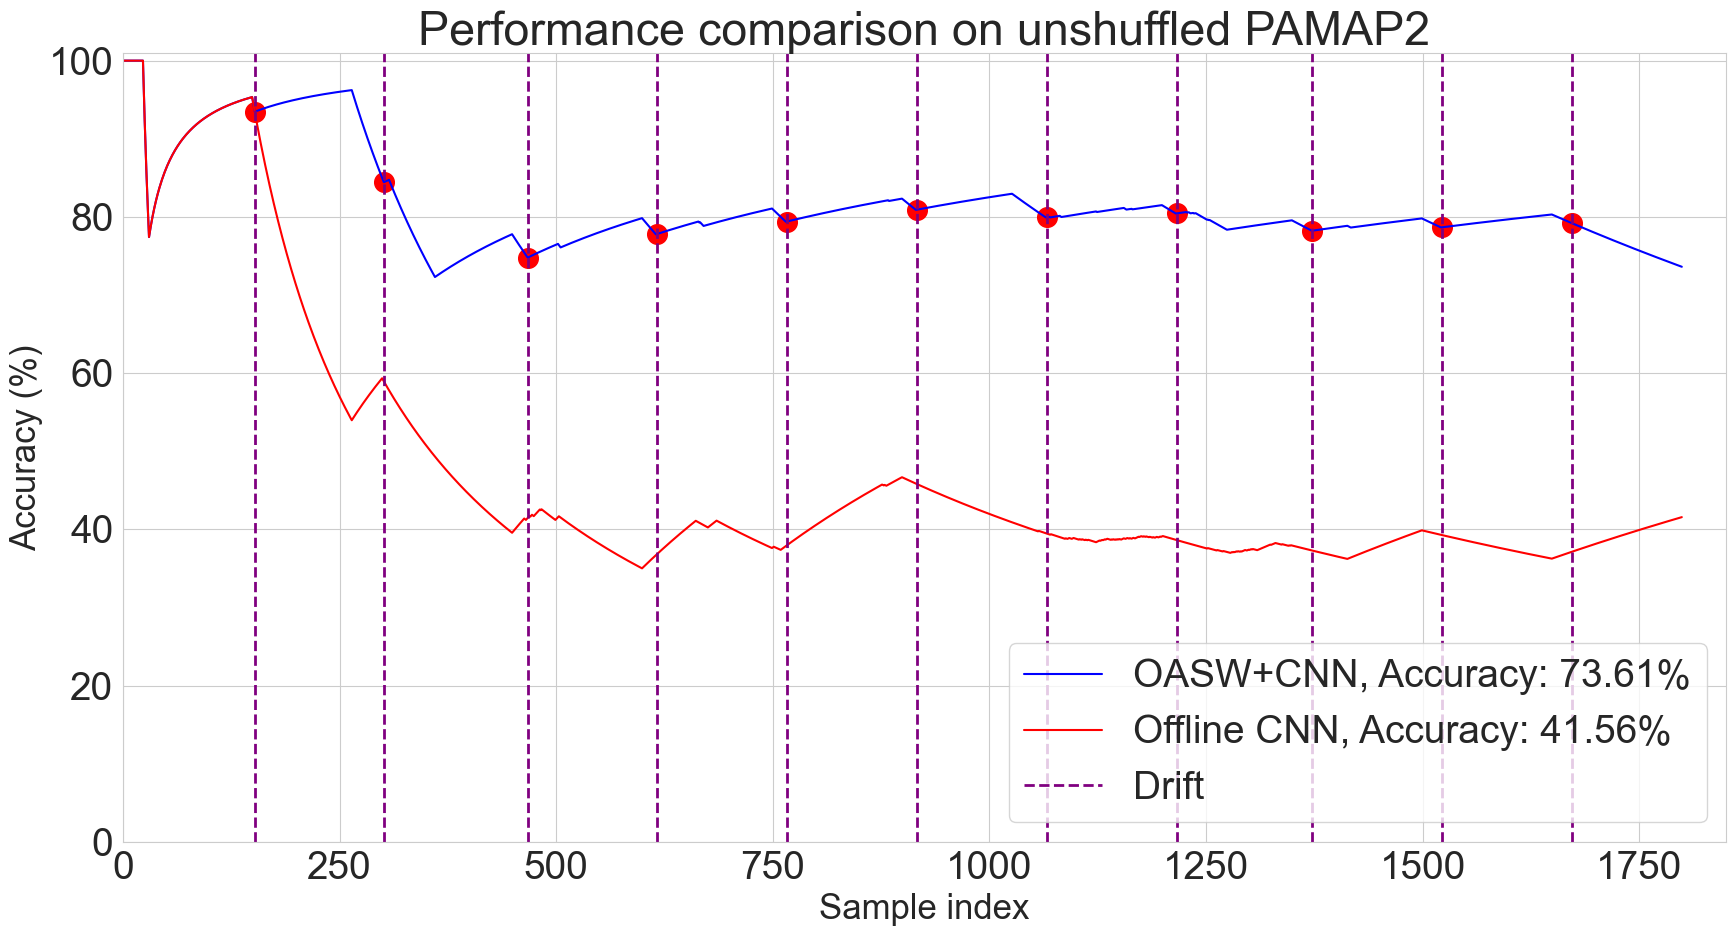

In [54]:
oasw_plot(t_oasw, m_oasw, dr, t_off, m_off)

# Optimizers

In [ ]:
import numpy as np
import copy
import pyswarms as ps

# Fonction objectif pour PSO
def pso_objective(x):
    # x est un tableau de shape (n_particles, n_params)
    scores = []
    for params in x:
        a, b, win1, win2 = params
        # Contraintes sur les bornes
        a = np.clip(a, 0.95, 0.999)
        b = np.clip(b, 0.95, 0.999)
        win1 = int(np.clip(win1, 10, 500))
        win2 = int(np.clip(win2, 100, 3500))
        mc = copy.deepcopy(model)
        score, _, _, _,_,_ = oasw(mc, torch.optim.Adam(mc.parameters(), lr=0.0005, weight_decay=1e-3), l, test_loader, a=a, b=b, win1=win1, win2=win2)
        # On veut maximiser, donc on retourne -score pour minimiser
        scores.append(-score)
    return np.array(scores)

# Définir les bornes pour chaque hyperparamètre
bounds = ([0.95, 0.95, 10, 100], [0.999, 0.999, 500, 3500])

# Initialiser l’optimiseur PSO
optimizer = ps.single.GlobalBestPSO(
    n_particles=8, dimensions=4, options={'c1': 0.5, 'c2': 0.3, 'w': 0.9},
    bounds=bounds
)

# Lancer l’optimisation
best_cost, best_pos = optimizer.optimize(pso_objective, iters=10)

print("Meilleurs paramètres (PSO):", best_pos)
print("Meilleure accuracy (PSO):", -best_cost)

In [ ]:
import optuna

def objective(trial):
    # Définir les plages de recherche pour chaque paramètre
    a = trial.suggest_float('a', 0.95, 0.999, step=0.001)
    b = trial.suggest_float('b', 0.95, 0.999, step=0.001)
    win1 = trial.suggest_int('win1', 10, 500, step=10)
    win2 = trial.suggest_int('win2', 100, 700, step=50)

    # Appeler OASW avec ces paramètres
    mc = copy.deepcopy(model)
    score, _, _, _,_,_ = oasw(mc, torch.optim.Adam(mc.parameters(), lr=0.0005, weight_decay=1e-3), l, test_loader,a=a, b=b, win1=win1, win2=win2)
    return score  # Maximiser l'accuracy

# Lancer l'optimisation
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)  # 30 essais, ajuste selon le temps dispo

# Afficher les meilleurs paramètres trouvés
print("Meilleurs paramètres :", study.best_params)
print("Meilleure accuracy :", study.best_value)

# Confusion Matrix

In [55]:
class_names = ['Lying', 'Sitting', 'Standing', 'Walking', 'Running', 'Cycling', 'Nordic walking',
               'Ascending stairs', 'Descending stairs', 'Vacuum cleaning', 'Ironing', 'Rope jumping']

Accuracy: 41.56%
F1 score: 37.51%
Recall: 41.56%


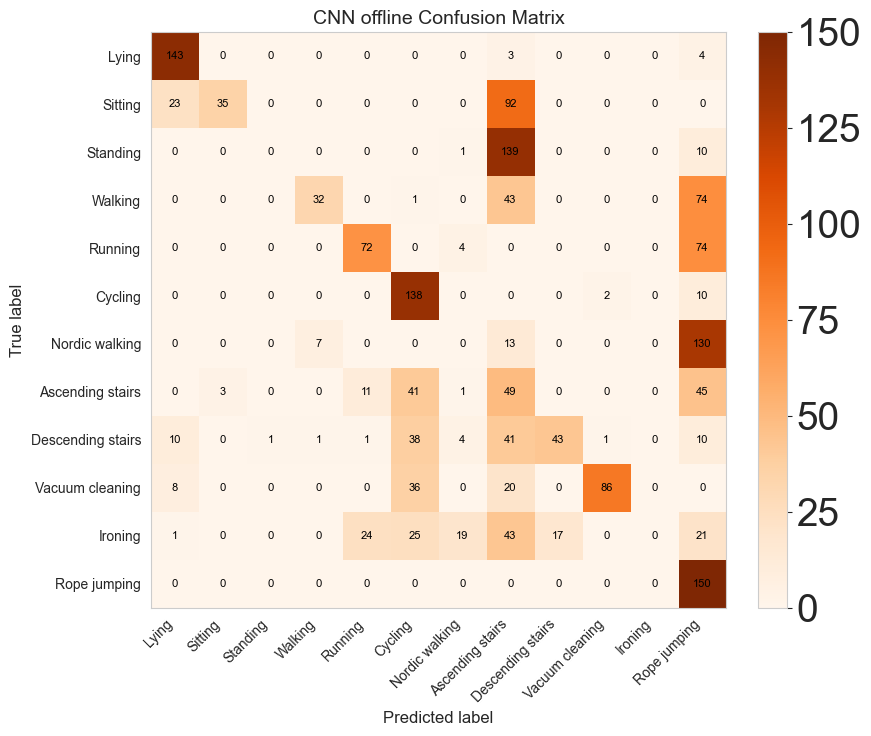

In [56]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score

cm = confusion_matrix(yt_cnn, yp_cnn)
acc = accuracy_score(yt_cnn, yp_cnn)
f1 = f1_score(yt_cnn, yp_cnn, average='weighted')
recall = recall_score(yt_cnn, yp_cnn, average='weighted')

print(f'Accuracy: {acc*100:.2f}%')
print(f'F1 score: {f1*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')

# Affichage de la matrice de confusion
plot_confusion(cm, class_names, title='CNN offline Confusion Matrix', save_title='CNN_offline_ConfusionMatrix_unshuffled_PAMAP2.pdf')


TEST RESULTS:
Accuracy OASW: 73.61%
F1 score OASW: 70.62%
Recall OASW: 73.61%

Plotting confusion matrix...


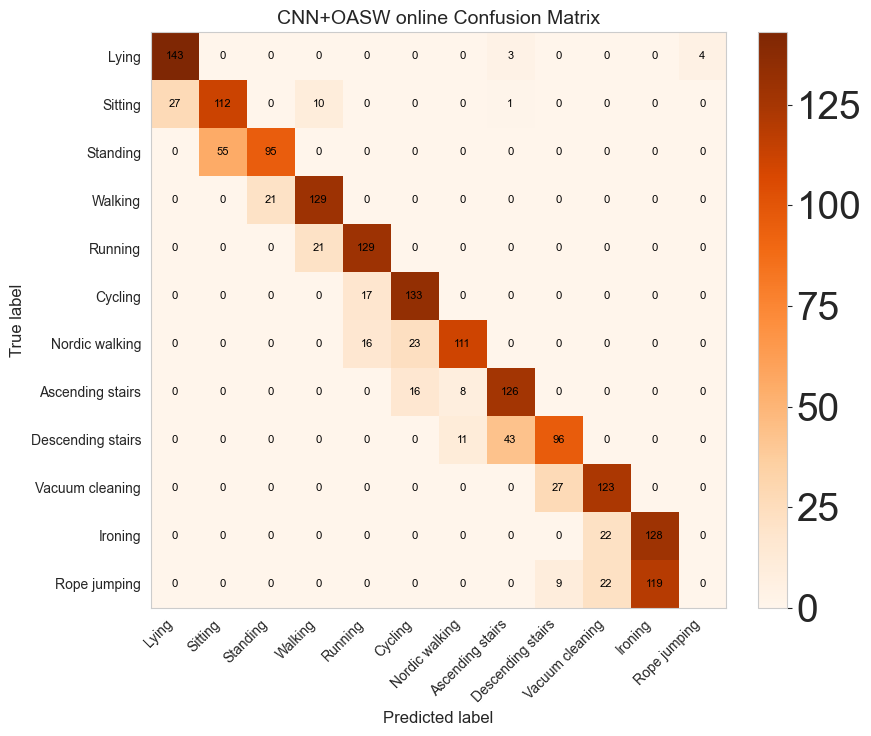

convnet(
  (layers): ModuleList(
    (0): conv_loss_block(
      (relu): ReLU(inplace=True)
      (encoder): Sequential(
        (0): Conv2d(1, 128, kernel_size=(6, 2), stride=(3, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
      )
      (decode_y0): Linear(in_features=204672, out_features=12, bias=True)
      (decode_y1): Linear(in_features=116736, out_features=12, bias=True)
      (decode_y2): Linear(in_features=42624, out_features=12, bias=True)
      (conv_loss): Sequential(
        (0): Conv2d(128, 128, kernel_size=(2, 1), stride=(2, 1), padding=(1, 0), bias=False)
      )
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
      (nonlin): ReLU(inplace=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (1): conv_loss_block(
      (relu): ReLU(inplace=True)
      (encoder): Sequential(
        (0): Conv2d(12

In [57]:
# Importer confusion_matrix si besoin
from sklearn.metrics import confusion_matrix

cm_oasw = confusion_matrix(yt, yp)
acc_oasw = accuracy_score(yt, yp)
f1_oasw = f1_score(yt, yp, average='weighted')
recall_oasw = recall_score(yt, yp, average='weighted')


print('\n' + '=' * 50)
print('TEST RESULTS:')
print(f'Accuracy OASW: {acc_oasw*100:.2f}%')
print(f'F1 score OASW: {f1_oasw*100:.2f}%')
print(f'Recall OASW: {recall_oasw*100:.2f}%')
print('=' * 50 + '\n')

print("Plotting confusion matrix...")
plot_confusion(cm_oasw, class_names,title='CNN+OASW online Confusion Matrix',save_title='CNN_OASW_ConfusionMatrix_unshuffled_PAMAP2.pdf')

torch.cuda.empty_cache()
gc.collect()
model_copy.train()